In [12]:
from labcams.io import mmap_dat
from labcams import *
import numpy as np
import pylab as plt

def nb_play_movie(data,interval=30,**kwargs):
    ''' 
    Play a movie from the notebook
    '''
    from ipywidgets import Play,jslink,HBox,IntSlider
    from IPython.display import display
    text = plt.text(10,10,'0',color='r')
    im = plt.imshow(data[0],**kwargs)
    slider = IntSlider(0,min = 0,max = len(data)-1,step = 1,description='Frame')
    play = Play(interval=interval,
                value=0,
                min=0,
                max=len(data)-1,
                step=1,
                description="Press play",
                disabled=False)
    jslink((play, 'value'), (slider, 'value'))
    display(HBox([play, slider]))
    def updateImage(change):
        im.set_data(data[change['new']])
        text.set_text(change['new'])
    slider.observe(updateImage, names='value')
    return dict(fig = plt.gcf(),
                ax=plt.gca(),
                im= im,
                update = updateImage)

fname = 'c:/data/1photon/2020_08_18_sync_long_opto_GCaMP/20200818_run002_00000002_68_160_uint16.dat'
shape = [int(f) for f in fname.split('_')[-3:-1]]
logfname = fname.replace('_'+'_'.join(fname.split('_')[-3:]),'.camlog')

dat = mmap_dat(fname,shape=shape)
log,led,sync,comm = parseCamLog(logfname,readTeensy=True)
sync

,sync,count,frame,timestamp
0,1.0,3,1529,3219.180000
1,1.0,3,1653,3469.180000
2,0.0,1,2151,4469.169922
3,0.0,1,61874,124468.093750


<IPython.core.display.Javascript object>


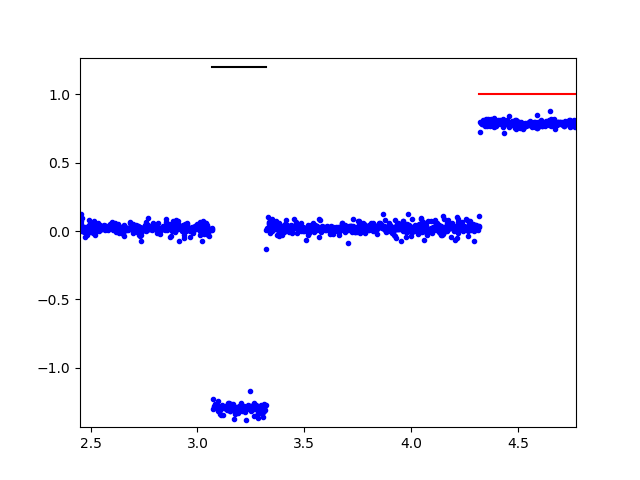

In [26]:
srate = 1./np.mean(np.diff(log.timestamp))
%matplotlib notebook
plt.figure()
if len(led) == len(dat):
    plt.vlines((led.frame-1)/srate,0.25,0.5)
plt.plot((sync[sync.sync == 1].frame-1)/srate,[1.2,1.2],color='k')    
plt.plot((sync[sync.sync == 0].frame-1)/srate,[1,1],color='r')
avg = np.mean(np.mean(dat - np.mean(dat[:10],axis=0),axis = 1),axis=1)
plt.plot(np.arange(len(avg))/srate,avg/np.max(avg),'b.')

In [25]:
print('Saved {0} frames and have logs for {1} [unique id diffs : {2}].'.format(len(dat),len(log),np.unique(np.diff(log.frame_id))))

Saved 62400 frames and have logs for 62400 [unique id diffs : [1]].


<IPython.core.display.Javascript object>


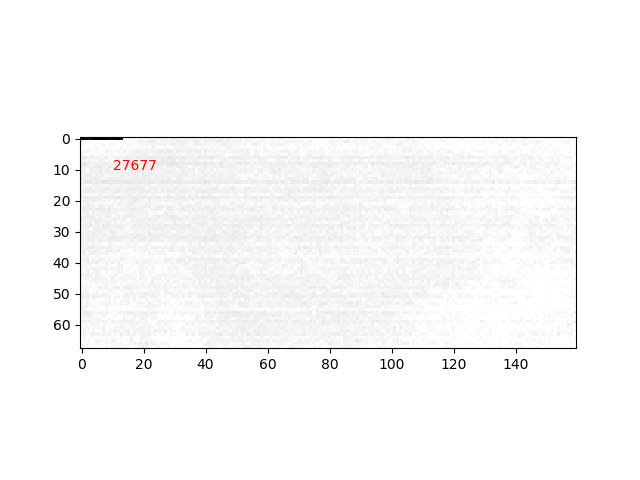

{'fig': <Figure size 640x480 with 1 Axes>,
 'ax': <matplotlib.axes._subplots.AxesSubplot at 0x271b1d8e808>,
 'im': <matplotlib.image.AxesImage at 0x271aeab12c8>,
 'update': <function __main__.nb_play_movie.<locals>.updateImage(change)>}

In [13]:
%matplotlib notebook
nb_play_movie(dat - np.mean(dat[:10]),cmap='gray')

In [80]:
def local_corr(block):
    """Computes the correlation image for the input dataset Y  using a faster FFT based method
    Parameters:
    -----------
    Y:  np.ndarray (3D or 4D)
        Input movie data in 3D or 4D format
    eight_neighbours: Boolean
        Use 8 neighbors if true, and 4 if false for 3D data (default = True)
        Use 6 neighbors for 4D data, irrespectively
    swap_dim: Boolean
        True indicates that time is listed in the last axis of Y (matlab format)
        and moves it in the front
    Returns:
    --------
    Cn: d1 x d2 [x d3] matrix, cross-correlation with adjacent pixels
    
    
    This is from CaIman: https://github.com/simonsfoundation/CaImAn/blob/master/caiman/summary_images.py
    """

    Y = np.array(block).astype('float32')
    Y -= np.nanmean(Y,axis = 0)
    Y /= np.nanstd(Y,axis = 0)

    sz = np.ones((3,3),dtype='float32')
    sz[1,1] = 0

    Yconv = convolve(Y,sz[np.newaxis,:],mode='constant')
    MASK = convolve(np.ones(Y.shape[1:],dtype='float32'),sz,mode='constant')
    Cn =  (np.nanmean(Yconv*Y,axis=0)/MASK).reshape([1]+[a for a in Y.shape[1:]]).astype(np.float32)
    return Cn